In [1]:
# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipdb
import platform
import h5py
import time
import scipy.io
from sklearn import linear_model
from scipy.optimize import curve_fit
opj = os.path.join
deb = ipdb.set_trace
%matplotlib inline
regr = linear_model.LinearRegression()
import skimage.color as color

# MRI imports
# -----------
import nibabel as nb
import cortex

# Functions
# ---------
def m(x, w):
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    # see https://www2.microstrategy.com/producthelp/archive/10.8/FunctionsRef/Content/FuncRef/WeightedCov__weighted_covariance_.htm
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def weighted_corr(x, y, w):
    # see https://www2.microstrategy.com/producthelp/10.4/FunctionsRef/Content/FuncRef/WeightedCorr__weighted_correlation_.htm
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

linear_function = lambda x, a, b: a * x + b


# Define colors
# -------------
transparency = 0.4



#subcortex colors
Pu_color            = (250/255.0, 190/255.0, 190/255.0,  1.0)
Ca_color            = (230/255.0,  25/255.0,  75/255.0,  1.0)
NAC_color           = (128/255.0,   0/255.0,   0/255.0,  1.0)
EXA_color           = (255/255.0, 215/255.0, 180/255.0,  1.0)
GPe_color           = (245/255.0, 130/255.0,  48/255.0,  1.0)
GPi_color           = (170/255.0, 110/255.0,  40/255.0,  1.0)
SNc_color           = (60/255.0, 180/255.0,  75/255.0,  1.0)
RN_color            = (70/255.0, 240/255.0, 240/255.0,  1.0)
SNr_color           = (0/255.0, 128/255.0, 128/255.0,  1.0)
PBP_color           = (170/255.0, 225/255.0, 195/255.0,  1.0)
VTA_color           = (255/255.0, 255/255.0, 200/255.0,  1.0)
VeP_color           = (255/255.0, 225/255.0,  25/255.0,  1.0)
HN_color            = (128/255.0, 128/255.0,   0/255.0,  1.0)
HTH_color           = (0/255.0, 130/255.0, 200/255.0,  1.0)
MN_color            = (0/255.0,   0/255.0, 128/255.0,  1.0)
STH_color           = (230/255.0, 190/255.0, 255/255.0,  1.0)

sub_colors = np.vstack((Pu_color,Ca_color,NAC_color,EXA_color,GPe_color,GPi_color,SNc_color,RN_color,SNr_color,PBP_color,VTA_color,VeP_color,HN_color,HTH_color,MN_color,STH_color))
sub_colors_alpha = np.vstack((Pu_color,Ca_color,NAC_color,EXA_color,GPe_color,GPi_color,SNc_color,RN_color,SNr_color,PBP_color,VTA_color,VeP_color,HN_color,HTH_color,MN_color,STH_color))
sub_colors_alpha[:,-1] = transparency


all_colors = np.vstack((sub_colors))
all_colors_alpha = np.vstack((sub_colors_alpha))
all_colors_alpha = color.rgba2rgb(all_colors_alpha.reshape((16,1,4)))
all_colors_alpha= all_colors_alpha.reshape(16,3)

vmin,vmax = -1,1


In [2]:
# Get data
# --------

# Define analysis parameters
# --------------------------
with open('/home/ada/projects/retino_HCP/settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Define cluster/server specific parameters
# -----------------------------------------
base_dir = analysis_info["{}_base_folder".format(platform.uname()[1])]  
fit_model = 'gauss'            

sign_idx, rsq_idx, ecc_idx, polar_real_idx, polar_imag_idx , size_idx, \
            non_lin_idx, amp_idx, baseline_idx, cov_idx, x_idx, y_idx, hemi_idx = 0,1,2,3,4,5,6,7,8,9,10,11,12


subjects = ['999999']


pprf_ecc_size_r             = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
pprf_ecc_size_r_std         = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
pprf_ecc_size_slope         = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
pprf_ecc_size_slope_std     = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
pprf_ecc_size_intercept     = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
pprf_ecc_size_intercept_std = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
pprf_contra_lat_idx         = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
pprf_contra_lat_idx_std     = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
pprf_vertex                 = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
pprf_vertex_std             = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan

pprf_ecc_val                = np.zeros((len(subjects),len(analysis_info['rois_subcortical']),10000))*np.nan
pprf_size_val               = np.zeros((len(subjects),len(analysis_info['rois_subcortical']),10000))*np.nan

nprf_ecc_size_r             = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
nprf_ecc_size_r_std         = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
nprf_ecc_size_slope         = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
nprf_ecc_size_slope_std     = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
nprf_ecc_size_intercept     = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
nprf_ecc_size_intercept_std = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
nprf_contra_lat_idx         = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
nprf_contra_lat_idx_std     = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
nprf_vertex                 = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan
nprf_vertex_std             = np.zeros((len(subjects),len(analysis_info['rois_subcortical'])))*np.nan

nprf_ecc_val                = np.zeros((len(subjects),len(analysis_info['rois_subcortical']),10000))*np.nan
nprf_size_val               = np.zeros((len(subjects),len(analysis_info['rois_subcortical']),10000))*np.nan

In [3]:
for mask_dir in ['pos','neg']:
    data_LR = []
    for sub_roi_num, sub_roi in enumerate(analysis_info['rois_subcortical']):
        for subject_num, subject in enumerate(subjects): 

            h5_dir = opj(base_dir,'pp_data','999999_bars_lisa',fit_model,'h5')

            data_hemi = []
            for hemi in ['L', 'R']:
                folder_alias = '{hemi}_{mask_dir}'.format(hemi = hemi,mask_dir = mask_dir)
                h5_file = h5py.File(opj(h5_dir,'{sub_roi}.h5'.format(sub_roi = sub_roi)), "r")
                in_file = opj("prf_deriv_{hemi}_{mask_dir}.func".format(hemi = hemi, mask_dir = mask_dir))
                data = h5_file['{folder_alias}/{in_file}'.format(folder_alias=folder_alias,in_file=in_file)]

                if hemi == 'L': val_hemi = 1
                elif hemi == 'R': val_hemi = 2
                data = np.vstack((data,val_hemi*np.ones((1,data.shape[1]))))

                data = data[:,:].T
                data_hemi.append(data)

            data_LR = np.row_stack((data_hemi[0],data_hemi[1]))

            data4mask = data_LR
            
            
            
            r_size_threshold_down = 0.1
            r_size_threshold_up = 12.0
            r_ecc_threshold_down = 0.1
            r_ecc_threshold_up = 12.0
            
            # thresholds
            size_th_down        = data4mask[:,size_idx]>= r_size_threshold_down
            size_th_up          = data4mask[:,size_idx]<= r_size_threshold_up
            ecc_th_down         = data4mask[:,ecc_idx]>= r_ecc_threshold_down
            ecc_th_up           = data4mask[:,ecc_idx]<= r_ecc_threshold_up         
            
            all_th              = np.array((size_th_down,size_th_up,ecc_th_down,ecc_th_up)) 
            data_LR             = data_LR[np.logical_and.reduce(all_th)]
            data_LR = data_LR[~np.isnan(data_LR[:,rsq_idx])]
            vertex = data_LR.shape[0]
            
            if vertex >= 2:
                new_order = np.random.permutation(vertex)
                data_LR = data_LR[new_order,:]

                ecc_data = data_LR[:,ecc_idx]
                size_data = data_LR[:,size_idx]
                weight_data = data_LR[:,rsq_idx]
                
                regr.fit(ecc_data.reshape(-1, 1), size_data.reshape(-1, 1),weight_data)
                
                ecc_size_r = weighted_corr(ecc_data,size_data,weight_data)
                ecc_size_slope = regr.coef_
                ecc_size_intercept = regr.intercept_
            else:
                ecc_size_r = np.nan
                ecc_size_slope = np.nan
                ecc_size_intercept = np.nan
            
            # compute laterality index
            data_L = data_LR[data_LR[:,hemi_idx]==1,:]
#             contra_lat_L = np.nansum(data_L[data_L[:,x_idx] < 0,rsq_idx])/np.nansum(data_L[:,rsq_idx])
            contra_lat_L = np.sum(data_L[:,x_idx] < 0)/data_L.shape[0]
            data_R = data_LR[data_LR[:,hemi_idx]==2,:]
#             contra_lat_R = np.nansum(data_R[data_R[:,x_idx] > 0,rsq_idx])/np.nansum(data_R[:,rsq_idx])
            contra_lat_R = np.sum(data_R[:,x_idx] > 0)/data_R.shape[0]
            contra_lat_idx = np.nanmean([contra_lat_L,contra_lat_R]) * (vmax-vmin) + vmin

            # save data
            if mask_dir == 'pos':
                pprf_ecc_size_r[subject_num,sub_roi_num] = ecc_size_r
                pprf_ecc_size_slope[subject_num,sub_roi_num] = ecc_size_slope
                pprf_ecc_size_intercept[subject_num,sub_roi_num] = ecc_size_intercept
                pprf_contra_lat_idx[subject_num,sub_roi_num] = contra_lat_idx
                pprf_vertex[subject_num,sub_roi_num] = vertex
                pprf_ecc_val[subject_num,sub_roi_num,0:vertex] = ecc_data[0:vertex]
                pprf_size_val[subject_num,sub_roi_num,0:vertex] = size_data[0:vertex]
            elif mask_dir == 'neg':
                nprf_ecc_size_r[subject_num,sub_roi_num] = ecc_size_r
                nprf_ecc_size_slope[subject_num,sub_roi_num] = ecc_size_slope
                nprf_ecc_size_intercept[subject_num,sub_roi_num] = ecc_size_intercept
                nprf_contra_lat_idx[subject_num,sub_roi_num] = contra_lat_idx
                nprf_vertex[subject_num,sub_roi_num] = vertex
                nprf_ecc_val[subject_num,sub_roi_num,0:vertex] = ecc_data[0:vertex]
                nprf_size_val[subject_num,sub_roi_num,0:vertex] = size_data[0:vertex]

In [15]:
# compute average across HCP subjects
#for sub_roi_num, sub_roi in enumerate(analysis_info['rois_subcortical']):
    #pprf_ecc_size_r[-1,sub_roi_num]             = np.nanmean(pprf_ecc_size_r[3:-1,sub_roi_num],axis = 0)
    #pprf_ecc_size_r_std[-1,sub_roi_num]         = np.nanstd(pprf_ecc_size_r[3:-1,sub_roi_num],axis=0,ddof=1)
    #pprf_ecc_size_slope[-1,sub_roi_num]         = np.nanmean(pprf_ecc_size_slope[3:-1,sub_roi_num],axis = 0)
    #pprf_ecc_size_slope_std[-1,sub_roi_num]     = np.nanstd(pprf_ecc_size_slope[3:-1,sub_roi_num],axis=0,ddof=1)
    #pprf_ecc_size_intercept[-1,sub_roi_num]     = np.nanmean(pprf_ecc_size_intercept[3:-1,sub_roi_num],axis = 0)
    #pprf_ecc_size_intercept_std[-1,sub_roi_num] = np.nanstd(pprf_ecc_size_intercept[3:-1,sub_roi_num],axis=0,ddof=1)
    #pprf_contra_lat_idx[-1,sub_roi_num]         = np.nanmean(pprf_contra_lat_idx[3:-1,sub_roi_num],axis = 0)
    #pprf_contra_lat_idx_std[-1,sub_roi_num]     = np.nanstd(pprf_contra_lat_idx[3:-1,sub_roi_num],axis=0,ddof=1)
    #pprf_vertex[-1,sub_roi_num]                 = np.nanmean(pprf_vertex[3:-1,sub_roi_num],axis = 0)
    #pprf_vertex_std[-1,sub_roi_num]             = np.nanstd(pprf_vertex[3:-1,sub_roi_num],axis=0,ddof=1)
    
    #nprf_ecc_size_r[-1,sub_roi_num]             = np.nanmean(nprf_ecc_size_r[3:-1,sub_roi_num],axis = 0)
    #nprf_ecc_size_r_std[-1,sub_roi_num]         = np.nanstd(nprf_ecc_size_r[3:-1,sub_roi_num],axis=0,ddof=1)
    #nprf_ecc_size_slope[-1,sub_roi_num]         = np.nanmean(nprf_ecc_size_slope[3:-1,sub_roi_num],axis = 0)
    #nprf_ecc_size_slope_std[-1,sub_roi_num]     = np.nanstd(nprf_ecc_size_slope[3:-1,sub_roi_num],axis=0,ddof=1)
    #nprf_ecc_size_intercept[-1,sub_roi_num]     = np.nanmean(nprf_ecc_size_intercept[3:-1,sub_roi_num],axis = 0)
    #nprf_ecc_size_intercept_std[-1,sub_roi_num] = np.nanstd(nprf_ecc_size_intercept[3:-1,sub_roi_num],axis=0,ddof=1)
    #nprf_contra_lat_idx[-1,sub_roi_num]         = np.nanmean(nprf_contra_lat_idx[3:-1,sub_roi_num],axis = 0)
    #nprf_contra_lat_idx_std[-1,sub_roi_num]     = np.nanstd(nprf_contra_lat_idx[3:-1,sub_roi_num],axis=0,ddof=1)
    #nprf_vertex[-1,sub_roi_num]                 = np.nanmean(nprf_vertex[3:-1,sub_roi_num],axis = 0)
    #nprf_vertex_std[-1,sub_roi_num]             = np.nanstd(nprf_vertex[3:-1,sub_roi_num],axis=0,ddof=1)

In [4]:
def plot_fig3():
    
    all_sub2draw = [0]
    
    # Define figure
    fig = plt.figure(figsize=(7.09*2.54, 3.75*2.54))
    grid = plt.GridSpec(6,4,hspace = 3,wspace = 0.2)

    # Figure 3A
    # ---------
    bg_col = (0.9, 0.9, 0.9)
    axis_width = 0.75
    line_width_corr = 1.5

    ax1 = fig.add_subplot(grid[0:3, 0])
    ax2 = fig.add_subplot(grid[0:3, 1])

    title_font = {'loc':'left','fontname':'Helvetica', 'fontsize':7, 'fontweight':'bold'}
    axis_tick_font = {'fontname':'Helvetica', 'fontsize':6}
    axis_label_font = {'fontname':'Helvetica', 'fontsize':7}

    sub_rois_len = np.arange(len(analysis_info['rois_subcortical']))
    bg_col = (0.9, 0.9, 0.9)
    axis_width = 0.75

    axs = ['ax1','ax2']

    # Titles 
    ax1.set_title('Subcortical areas',**title_font)
    ax2.set_title('Subcortical areas',**title_font)

    # Remove left and top line and make axis right size
    for ax in axs:
        exec("{}.spines['top'].set_visible(False)".format(ax))
        exec("{}.spines['right'].set_visible(False)".format(ax))
        exec("{}.spines['left'].set_linewidth(axis_width)".format(ax))
        exec("{}.spines['bottom'].set_linewidth(axis_width)".format(ax))

    # Define background color
    for ax in axs:
        exec("{}.set_facecolor(bg_col)".format(ax))

    # X min and X ticknum
    xmin1,xmax1 = 0,10
    xmin2,xmax2 = 0,10
    x_tick_num1 = 6
    x_tick_num2 = 6 

    # Y min and  Y ticknum
    ymin1,ymax1 = 0,10
    ymin2,ymax2 = 0,10
    y_tick_num1 = 6 
    y_tick_num2 = 6 

    # Y lim
    ax1.set_ylim(bottom=ymin1, top=ymax1)
    ax2.set_ylim(bottom=ymin2, top=ymax2)

    # Y label
    ax1.set_ylabel('+pRF size (dva)',axis_label_font)
    ax2.set_ylabel('-pRF size (dva)',axis_label_font)

    # Y Ticks
    y_tick1 = np.linspace(ymin1,ymax1,y_tick_num1)
    y_tick2 = np.linspace(ymin2,ymax2,y_tick_num2)
    ax1.set_yticks(y_tick1)
    ax2.set_yticks(y_tick2)

    # Y Tickslabel
    y_tick_label1 = []
    for t in zip(y_tick1):y_tick_label1.append('%2.0f'%t)
    ax1.set_yticklabels(y_tick_label1,**axis_tick_font)
    y_tick_label2 = []
    for t in zip(y_tick2):y_tick_label2.append('%2.0f'%t)
    ax2.set_yticklabels(y_tick_label2,**axis_tick_font)

    # X lim
    ax1.set_xlim(left=xmin1, right=xmax1)
    ax2.set_xlim(left=xmin2, right=xmax2)

    # X label
    ax1.set_xlabel('+pRF eccentricity (dva)',axis_label_font)
    ax2.set_xlabel('-pRF eccentricity (dva)',axis_label_font)

    
    # X Ticks
    x_tick1 = np.linspace(xmin1,xmax1,x_tick_num1)
    x_tick2 = np.linspace(xmin2,xmax2,x_tick_num2)
    ax1.set_xticks(x_tick1)
    ax2.set_xticks(x_tick2)

    # X Tickslabel
    x_tick_label1 = []
    for t in zip(x_tick1):x_tick_label1.append('%2.0f'%t)
    ax1.set_xticklabels(x_tick_label1,**axis_tick_font)
    x_tick_label2 = []
    for t in zip(x_tick2):x_tick_label2.append('%2.0f'%t)
    ax2.set_xticklabels(x_tick_label2,**axis_tick_font)


    # plot eccentricity.size low level vision
    # ---------------------------------------
    
    subject_num = 0
    sub_rois_selection = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    for sub_roi_num in sub_rois_selection:
        all_ecc_val = pprf_ecc_val[subject_num,sub_roi_num,:]
        all_size_val = pprf_size_val[subject_num,sub_roi_num,:]
        ax1.plot(all_ecc_val,all_size_val,'o', markersize = 3, color= all_colors_alpha[sub_roi_num], markeredgewidth=0)
    
    for sub_roi_num in sub_rois_selection:
        x_ecc_size = x_tick1
        slope_val = pprf_ecc_size_slope[subject_num,sub_roi_num]
        intercept_val = pprf_ecc_size_intercept[subject_num,sub_roi_num]
        y_ecc_size = linear_function(x_ecc_size,slope_val,intercept_val)
        ax1.plot(x_ecc_size,y_ecc_size,color= all_colors[sub_roi_num] ,linewidth=line_width_corr)
        
        
    rois_selection = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    for sub_roi_num in sub_rois_selection:
        all_ecc_val = nprf_ecc_val[subject_num,sub_roi_num,:]
        all_size_val = nprf_size_val[subject_num,sub_roi_num,:]
        ax2.plot(all_ecc_val,all_size_val,'o', markersize = 3, color= all_colors_alpha[sub_roi_num], markeredgewidth=0)

    for sub_roi_num in sub_rois_selection:
        x_ecc_size = x_tick1
        slope_val = nprf_ecc_size_slope[subject_num,sub_roi_num]
        intercept_val = nprf_ecc_size_intercept[subject_num,sub_roi_num]
        y_ecc_size = linear_function(x_ecc_size,slope_val,intercept_val)
        ax2.plot(x_ecc_size,y_ecc_size,color = all_colors[sub_roi_num],linewidth=line_width_corr)
         

    # Figure 3B
    # ---------
    ax3  = fig.add_subplot(grid[0:2, 2])
    ax4  = fig.add_subplot(grid[0:2, 3])
    ax5  = fig.add_subplot(grid[2:4, 2])
    ax6  = fig.add_subplot(grid[2:4, 3])

    # Settings
    axs = ['ax3','ax4','ax5','ax6']

    # Titles   
    ax3.set_title('Subcortical areas',**title_font)
    ax5.set_title('Subcortical areas',**title_font)

    # Remove left and top line and make axis right size
    for ax in axs:
        exec("{}.spines['top'].set_visible(False)".format(ax))
        exec("{}.spines['right'].set_visible(False)".format(ax))
        exec("{}.spines['left'].set_linewidth(axis_width)".format(ax))
        exec("{}.spines['bottom'].set_linewidth(axis_width)".format(ax))

    # Define background color
    for ax in axs:
        exec("{}.set_facecolor(bg_col)".format(ax))

        
    # Y min and Y tick num
    ymin3,ymax3 = -1,1
    ymin4,ymax4 = -1,1
    ymin5,ymax5 = -1,1
    ymin6,ymax6 = -1,1
    y_tick_num3 = 5 
    y_tick_num4 = 5 
    y_tick_num5 = 5
    y_tick_num6 = 5

        
    # Y lim
    ax3.set_ylim(bottom=ymin3, top=ymax3)
    ax4.set_ylim(bottom=ymin4, top=ymax4)
    ax5.set_ylim(bottom=ymin5, top=ymax5)
    ax6.set_ylim(bottom=ymin6, top=ymax6)

    # Y label
    ax3.set_ylabel('+pRF\nr [ECCENTRICITY.SIZE]',axis_label_font)
    ax4.set_ylabel('+pRF\nlaterality index',axis_label_font)
    ax5.set_ylabel('-pRF\nr [ECCENTRICITY.SIZE]',axis_label_font)
    ax6.set_ylabel('-pRF\nlaterality index',axis_label_font)

    # Y Ticks
    y_tick3 = np.linspace(ymin3,ymax3,y_tick_num3)
    y_tick4 = np.linspace(ymin4,ymax4,y_tick_num4)
    y_tick5 = np.linspace(ymin5,ymax5,y_tick_num5)
    y_tick6 = np.linspace(ymin6,ymax6,y_tick_num6)
    ax3.set_yticks(y_tick3)
    ax4.set_yticks(y_tick4)
    ax5.set_yticks(y_tick5)
    ax6.set_yticks(y_tick6)

    # Y Tick label
    y_tick_label3 = []
    for t in zip(y_tick3):y_tick_label3.append('%1.2g'%t)
    y_tick_label4 = []
    for t in zip(y_tick4):y_tick_label4.append('%1.2g'%t)
    y_tick_label5 = []
    for t in zip(y_tick5):y_tick_label5.append('%1.2g'%t)
    y_tick_label6 = []
    for t in zip(y_tick6):y_tick_label6.append('%1.2g'%t)
    ax3.set_yticklabels(y_tick_label3,**axis_tick_font)
    ax4.set_yticklabels(y_tick_label4,**axis_tick_font)
    ax5.set_yticklabels(y_tick_label5,**axis_tick_font)
    ax6.set_yticklabels(y_tick_label6,**axis_tick_font)


    # X Ticks
    ax3.set_xticks(sub_rois_len)
    ax4.set_xticks(sub_rois_len)
    ax5.set_xticks(sub_rois_len)
    ax6.set_xticks(sub_rois_len)

    # X lim
    ax3.set_xlim(left=sub_rois_len[0]-1, right=sub_rois_len[-1]+1)
    ax4.set_xlim(left=sub_rois_len[0]-1, right=sub_rois_len[-1]+1)
    ax5.set_xlim(left=sub_rois_len[0]-1, right=sub_rois_len[-1]+1)
    ax6.set_xlim(left=sub_rois_len[0]-1, right=sub_rois_len[-1]+1)

    # X Ticks Label
    ax3.set_xticklabels(analysis_info['rois_subcortical'],**axis_tick_font,rotation = 45)
    ax4.set_xticklabels(analysis_info['rois_subcortical'],**axis_tick_font,rotation = 45)
    ax5.set_xticklabels(analysis_info['rois_subcortical'],**axis_tick_font,rotation = 45)
    ax6.set_xticklabels(analysis_info['rois_subcortical'],**axis_tick_font,rotation = 45)
   
    # zero lines
    line_x_sub = np.arange(sub_rois_len[0]-1,sub_rois_len[-1]+2)
    ax3.plot(line_x_sub,line_x_sub*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax4.plot(line_x_sub,line_x_sub*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax5.plot(line_x_sub,line_x_sub*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax6.plot(line_x_sub,line_x_sub*0,color = [0.5,0.5,0.5],linewidth = axis_width)

    
    # text legend
    sub_text_x = sub_rois_len[-1]+1 - (sub_rois_len[-1]+1)*0.05
    ax4.text(sub_text_x, 0.5, 'ipsi.', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax4.text(sub_text_x, -0.5, 'contra.', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax6.text(sub_text_x, 0.5, 'ipsi.', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax6.text(sub_text_x, -0.5, 'contra.', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
   
    # define colors
    ax3_col = sub_colors
    ax4_col = sub_colors
    ax5_col = sub_colors
    ax6_col = sub_colors
  
    
    # define bar distance and width
    dist_sub =  0.15 * (3.0/len(all_sub2draw))
    width_sub =  0.15 * (3.0/len(all_sub2draw))

    # Plot all data
    # -------------    
            
    for sub2draw_num,sub2draw in enumerate(all_sub2draw):
        rois_sub = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

        # r[ECCENTRICITY.SIZE]
        # --------------------
        ax3_x = np.arange(len(rois_sub))  + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_sub*(len(all_sub2draw)/3.0))
        ax5_x = np.arange(len(rois_sub)) + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_sub*(len(all_sub2draw)/3.0))
      
        ax3_y,ax5_y = pprf_ecc_size_r[sub2draw,rois_sub],nprf_ecc_size_r[sub2draw,rois_sub]
        ax3.bar(ax3_x,ax3_y,color = ax3_col, width = width_sub)
        ax5.bar(ax5_x,ax5_y,color = ax5_col,width = width_sub)

        if sub2draw == 184:
            ax3_yerr = pprf_ecc_size_r_std[sub2draw,rois_sub]
            ax5_yerr = nprf_ecc_size_r_std[sub2draw,rois_sub]
            ax3.errorbar(ax3_x,ax3_y,[ax3_yerr*0,ax3_yerr], xerr = None, ecolor = ax3_col, elinewidth = 0.5, linestyle = 'none')
            ax3.errorbar(ax3_x,ax3_y,[ax3_yerr,ax3_yerr*0], xerr = None, ecolor = bg_col, elinewidth = 0.5, linestyle = 'none')
            ax5.errorbar(ax5_x,ax5_y,[ax5_yerr*0,ax5_yerr], xerr = None, ecolor = ax5_col, elinewidth = 0.5, linestyle = 'none')
            ax5.errorbar(ax5_x,ax5_y,[ax5_yerr,ax5_yerr*0], xerr = None, ecolor = bg_col, elinewidth = 0.5, linestyle = 'none')
          
        # Laterality index
        # ----------------
        ax4_x = np.arange(len(rois_sub))  + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_sub*(len(all_sub2draw)/3.0))
        ax6_x = np.arange(len(rois_sub)) + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_sub*(len(all_sub2draw)/3.0))
        
        ax4_y,ax6_y = pprf_contra_lat_idx[sub2draw,rois_sub],nprf_contra_lat_idx[sub2draw,rois_sub]
        ax4.bar(ax4_x,ax4_y,color = ax4_col, width = width_sub)
        ax6.bar(ax6_x,ax6_y,color = ax6_col,width = width_sub)
       
        if sub2draw == 184:
            ax4_yerr = pprf_contra_lat_idx_std[sub2draw,rois_sub]
            ax6_yerr = nprf_contra_lat_idx_std[sub2draw,rois_sub]
            ax4.errorbar(ax4_x,ax4_y,[ax4_yerr,ax4_yerr*0], xerr = None, ecolor = ax4_col, elinewidth = 0.5, linestyle = 'none')
            ax4.errorbar(ax4_x,ax4_y,[ax4_yerr*0,ax4_yerr], xerr = None, ecolor = bg_col, elinewidth = 0.5, linestyle = 'none')
            ax6.errorbar(ax6_x,ax6_y,[ax6_yerr,ax6_yerr*0], xerr = None, ecolor = ax6_col, elinewidth = 0.5, linestyle = 'none')
            ax6.errorbar(ax6_x,ax6_y,[ax6_yerr*0,ax6_yerr], xerr = None, ecolor = bg_col, elinewidth = 0.5, linestyle = 'none')
           

In [39]:
img_dir1 = '/home/ada/projects/retino_HCP/post_fit/notebooks/figs/FigureSubcortex/'
try: os.makedirs(img_dir1)
except: pass

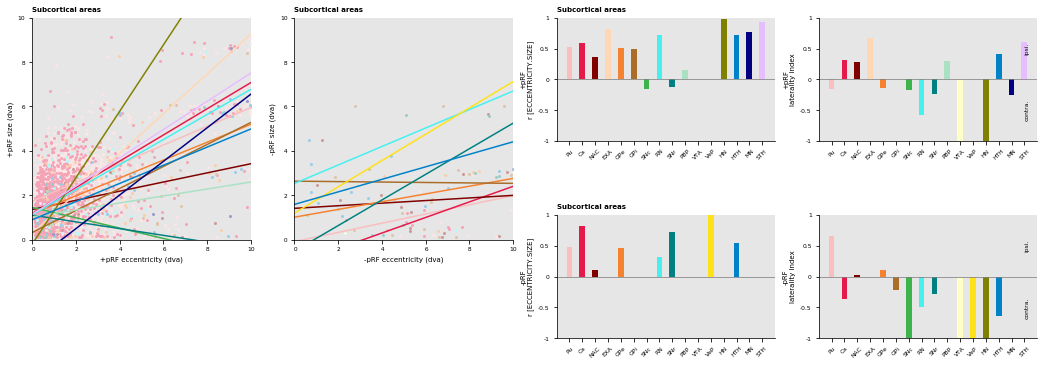

In [40]:
plot_fig3()
plt.savefig("{imdir}ecc_size_bars_suball.pdf".format(imdir = img_dir1),facecolor='w')

In [5]:
# Subcortical areas PPRF and NPRF
subject2print_num = [0]
rois_sub = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for subject_num in subject2print_num:
    
    pprf_ecc_size_r_mean        = np.nanmean(pprf_ecc_size_r[subject_num,rois_sub])
    pprf_ecc_size_r_std         = np.nanstd(pprf_ecc_size_r[subject_num,rois_sub],axis=0,ddof=1)
    pprf_contra_lat_idx_mean    = np.nanmean(pprf_contra_lat_idx[subject_num,rois_sub])
    pprf_contra_lat_idx_std     = np.nanstd(pprf_contra_lat_idx[subject_num,rois_sub],axis=0,ddof=1)

    print("Subcortical areas: {} ({}): +pPR r = {:1.2f} ± {:1.2f}, +pRF contra-laterality index: {:1.2f} ± {:1.2f}".format(subjects[subject_num],
                                                                                                                                subject_num,
                                                                                                                                pprf_ecc_size_r_mean,
                                                                                                                                pprf_ecc_size_r_std,
                                                                                                                                pprf_contra_lat_idx_mean,
                                                                                                                                pprf_contra_lat_idx_std))
    

    
    
    
    nprf_ecc_size_r_mean          = np.nanmean(nprf_ecc_size_r[subject_num,rois_sub])
    nprf_ecc_size_r_mean_std      = np.nanstd(nprf_ecc_size_r[subject_num,rois_sub],axis=0,ddof=1)
    nprf_contra_lat_idx_mean      = np.nanmean(nprf_contra_lat_idx[subject_num,rois_sub])
    nprf_contra_lat_idx_mean_std  = np.nanstd(nprf_contra_lat_idx[subject_num,rois_sub],axis=0,ddof=1)

    print("Subcortical areas: {} ({}): -pPR r = {:1.2f} ± {:1.2f}, -pRF contra-laterality index: {:1.2f} ± {:1.2f}".format(subjects[subject_num],
                                                                                                                                subject_num,
                                                                                                                                nprf_ecc_size_r_mean,
                                                                                                                                nprf_ecc_size_r_mean_std,
                                                                                                                                nprf_contra_lat_idx_mean,
                                                                                                                                nprf_contra_lat_idx_mean_std))
    







Subcortical areas: 999999 (0): +pPR r = 0.52 ± 0.36, +pRF contra-laterality index: -0.06 ± 0.51
Subcortical areas: 999999 (0): -pPR r = 0.49 ± 0.33, -pRF contra-laterality index: -0.43 ± 0.53


In [14]:
# Habenular nuclei PPRF and NPRF
subject2print_num = [0]
rois_sub = [12]
for subject_num in subject2print_num:
    
    pprf_ecc_size_r_mean        = np.nanmean(pprf_ecc_size_r[subject_num,rois_sub])
    pprf_ecc_size_r_std         = np.nanstd(pprf_ecc_size_r[subject_num,rois_sub],axis=0,ddof=1)
    pprf_contra_lat_idx_mean    = np.nanmean(pprf_contra_lat_idx[subject_num,rois_sub])
    pprf_contra_lat_idx_std     = np.nanstd(pprf_contra_lat_idx[subject_num,rois_sub],axis=0,ddof=1)

    print("Subcortical areas: {} ({}): +pPR r = {:1.2f} ± {:1.2f}, +pRF contra-laterality index: {:1.2f} ± {:1.2f}".format(subjects[subject_num],
                                                                                                                                subject_num,
                                                                                                                                pprf_ecc_size_r_mean,
                                                                                                                                pprf_ecc_size_r_std,
                                                                                                                                pprf_contra_lat_idx_mean,
                                                                                                                                pprf_contra_lat_idx_std))
    

    
    
    
    nprf_ecc_size_r_mean          = np.nanmean(nprf_ecc_size_r[subject_num,rois_sub])
    nprf_ecc_size_r_mean_std      = np.nanstd(nprf_ecc_size_r[subject_num,rois_sub],axis=0,ddof=1)
    nprf_contra_lat_idx_mean      = np.nanmean(nprf_contra_lat_idx[subject_num,rois_sub])
    nprf_contra_lat_idx_mean_std  = np.nanstd(nprf_contra_lat_idx[subject_num,rois_sub],axis=0,ddof=1)

    print("Subcortical areas: {} ({}): -pPR r = {:1.2f} ± {:1.2f}, -pRF contra-laterality index: {:1.2f} ± {:1.2f}".format(subjects[subject_num],
                                                                                                                                subject_num,
                                                                                                                                nprf_ecc_size_r_mean,
                                                                                                                                nprf_ecc_size_r_mean_std,
                                                                                                                                nprf_contra_lat_idx_mean,
                                                                                                                                nprf_contra_lat_idx_mean_std))
    








Subcortical areas: 999999 (0): +pPR r = 0.94 ± nan, +pRF contra-laterality index: 0.60 ± nan
Subcortical areas: 999999 (0): -pPR r = nan ± nan, -pRF contra-laterality index: nan ± nan
